In [1]:
import TimeTagger
import numpy as np
%matplotlib ipympl
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numba

In [2]:
dump_file = r"Z:\PriyaM\swabian_data\20230712_tissue\test_tissue_2023-07-12_154752.1.ttbin"

In [3]:
tagger = TimeTagger.createTimeTaggerVirtual()

In [31]:
histo = TimeTagger.StartStop(tagger,-4,4,48)

In [32]:
tagger.setReplaySpeed(-1)
tagger.replay(dump_file)
tagger.waitForCompletion()

True

In [43]:
x =histo.getData()

In [68]:
y = x.flatten()

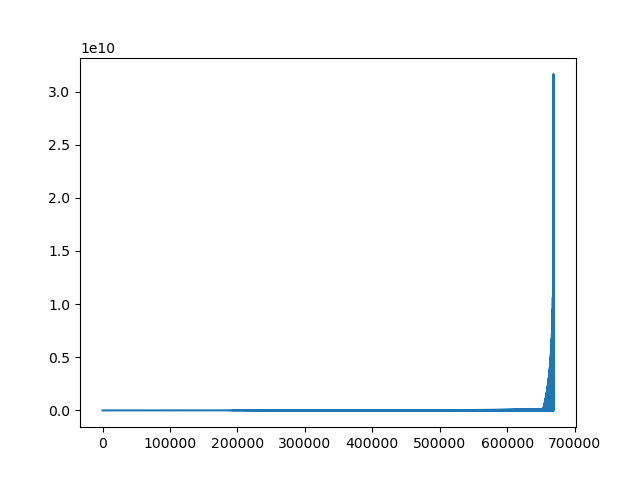

In [69]:
plt.close()
plt.plot(y)
plt.show()

## channel/channel example (photon mean per channel)

In [5]:
arr = []

photon = 4
frame = 3

In [82]:
class PhotonMean(TimeTagger.CustomMeasurement):
    """
    CustomMeasurement that gets channel_1/channel_2.
    """

    def __init__(self, tagger, channels):
        TimeTagger.CustomMeasurement.__init__(self, tagger)
        self.channels = list(channels)
        self.counts = np.zeros((len(channels),), dtype=np.int32)

        # Each used channel must be registered
        for channel in channels:
            self.register_channel(channel)

        self.clear_impl()

        # At the end of a Measurement construction we must indicate that we
        # have finished
        self.finalize_init()

    def __del__(self):
        # The measurement must be stopped before deconstruction to avoid
        # concurrent measure() calls
        self.stop()

    def getData(self):
        # lock this instance to avoid conflicting results while measure is
        # running apart.
        with self.mutex:
            counts = np.array(self.counts)
        if counts[1]!=0:
            return counts[0]/counts[1]
        else:
            return "no frames yet"

    def getIndex(self):
        # this method does not depend on the internal state, so there is no
        # need for a lock
        return list(self.channels)

    def clear_impl(self):
        # the lock is already acquired
        self.counts *= 0

    def on_start(self):
        # the lock is already acquired
        pass

    def on_stop(self):
        # the lock is already acquired
        pass

    def process(self, incoming_tags, begin_time, end_time):
        # the lock is already acquired
        # self.data is provided as reference, so it must not be accessed
        # anywhere else without locking the mutex.
        # incoming_tags is provided as a read-only reference. The storage will
        # be deallocated after this call, so you must not store a reference to
        # this object. Make a copy instead.
        channel_numbers, counts = np.unique(incoming_tags["channel"], return_counts=True)
        for channel_number, count in zip(channel_numbers, counts):
            self.counts[self.channels.index(channel_number)] += count
            
            if count%1E5:
                arr.append(count)

In [58]:
tagger = TimeTagger.createTimeTaggerVirtual()

In [80]:
slider_duration = widgets.IntSlider(
    orientation='horizontal',
    description='Duration (ps):',
    step=.5E12,
    min=0,
    max=45E12
)

slider_begin = widgets.IntSlider(
    orientation='horizontal',
    description='Start at (ps):',
    step=.5E12,
    min=0,
    max=45E12
)

slider_duration.layout.width = '60%'
slider_begin.layout.width = '60%'


In [106]:
arr3= [1,2,1,3,4,5,6,7,7,8,5,3,2,4,5,6,3,2,2,1,4,5,7,8,4,5,6]
np.unique(arr3, return_counts = True)

(array([1, 2, 3, 4, 5, 6, 7, 8]), array([3, 4, 3, 4, 5, 3, 3, 2], dtype=int64))

In [81]:

def update_duration(begin, duration):
    arr.clear()
    tagger.reset()
    photon_mean = PhotonMean(tagger, channels=[photon, frame])
    
    tagger.setReplaySpeed(-1)
    replay = tagger.replay(dump_file, begin=begin, duration=duration)
    tagger.waitForCompletion()
    
    photon_mean_data = photon_mean.getData()
    print("mean photons per frame:", photon_mean_data)
    
    print("length= ",len(arr), '\n', arr)
    
widgets.interact(update_duration, begin=slider_begin, duration=slider_duration)


interactive(children=(IntSlider(value=0, description='Start at (ps):', layout=Layout(width='60%'), max=4500000…

<function __main__.update_duration(begin, duration)>

# Photon median

In [ ]:
279827555654787 | 279827555661643

In [20]:
(279827555661643-279827555654787)/48

142.83333333333334

In [23]:
class PhotonMedian(TimeTagger.CustomMeasurement):
    """
    
    """

    def __init__(self, tagger, start_channel, binwidth, n_bins):
        TimeTagger.CustomMeasurement.__init__(self, tagger)
        self.start_channel = start_channel
        self.binwidth = binwidth
        self.max_bins = n_bins

        # The method register_channel(channel) activates
        # that data from the respective channels is transferred
        # from the Time Tagger to the PC.
        self.register_channel(channel=start_channel)

        self.clear_impl()

        # At the end of a CustomMeasurement construction,
        # we must indicate that we have finished.
        self.finalize_init()

    def __del__(self):
        # The measurement must be stopped before deconstruction to avoid
        # concurrent process() calls.
        self.stop()

    def getData(self):
        # Acquire a lock this instance to guarantee that process() is not running in parallel
        # This ensures to return a consistent data.
        with self.mutex:
            return self.data.copy()

    def getIndex(self):
        # This method does not depend on the internal state, so there is no
        # need for a lock.
        arr = np.arange(0, self.max_bins) * self.binwidth
        return arr

    def clear_impl(self):
        # The lock is already acquired within the backend.
        self.last_start_timestamp = 0
        self.data = np.zeros((self.max_bins,), dtype=np.uint64)

    def on_start(self):
        # The lock is already acquired within the backend.
        pass

    def on_stop(self):
        # The lock is already acquired within the backend.
        pass

    @staticmethod
    @numba.jit(nopython=True, nogil=True)
    def fast_process(
            tags,
            data,
            start_channel,
            binwidth,
            last_start_timestamp):
        """
        A precompiled version of the histogram algorithm for better performance
        nopython=True: Only a subset of the python syntax is supported.
                       Avoid everything but primitives and numpy arrays.
                       All slow operation will yield an exception
        nogil=True:    This method will release the global interpreter lock. So
                       this method can run in parallel with other python code
        """
        for tag in tags:
            # tag.type can be: 0 - TimeTag, 1- Error, 2 - OverflowBegin, 3 -
            # OverflowEnd, 4 - MissedEvents (you can use the TimeTagger.TagType IntEnum)
            if tag['type'] == TimeTagger.TagType.TimeTag and tag['channel'] == click_channel:
            # valid event
                index = (tag['time'] - last_start_timestamp) // binwidth
                if index < data.shape[0]:
                    data[index] += 1
            if tag['channel'] == start_channel:
                last_start_timestamp = tag['time']
                    
        return last_start_timestamp

    def process(self, incoming_tags, begin_time, end_time):
        """
        Main processing method for the incoming raw time-tags.

        The lock is already acquired within the backend.
        self.data is provided as reference, so it must not be accessed
        anywhere else without locking the mutex.

        Parameters
        ----------
        incoming_tags
            The incoming raw time tag stream provided as a read-only reference.
            The storage will be deallocated after this call, so you must not store a reference to
            this object. Make a copy instead.
            Please note that the time tag stream of all channels is passed to the process method,
            not only the ones from register_channel(...).
        begin_time
            Begin timestamp of the of the current data block.
        end_time
            End timestamp of the of the current data block.
        """
        self.last_start_timestamp = PhotonMedian.fast_process(
            incoming_tags,
            self.data,
            self.start_channel,
            self.binwidth,
            self.last_start_timestamp)


Traceback (most recent call last):
  File "C:\Program Files\Swabian Instruments\Time Tagger\driver\python\TimeTagger.py", line 5011, in next_impl
    self.process(tags, begin_time, end_time)
  File "C:\Users\lociu\AppData\Local\Temp\ipykernel_9200\2013594441.py", line 102, in process
    self.last_start_timestamp = PhotonMedian.fast_process(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\lociu\anaconda\envs\swabian\Lib\site-packages\numba\core\dispatcher.py", line 468, in _compile_for_args
    error_rewrite(e, 'typing')
  File "C:\Users\lociu\anaconda\envs\swabian\Lib\site-packages\numba\core\dispatcher.py", line 409, in error_rewrite
    raise e.with_traceback(None)
numba.core.errors.TypingError: Failed in nopython mode pipeline (step: nopython frontend)
NameError: name 'click_channel' is not defined


In [22]:
tagger.reset()
photon_med = PhotonMedian(tagger, 4, 48, 256)

tagger.setReplaySpeed(-1)
replay = tagger.replay(dump_file)
tagger.waitForCompletion()

True

In [15]:
photon_med.getData().shape[0]

256

In [14]:
photon_med.getIndex().shape

(256,)

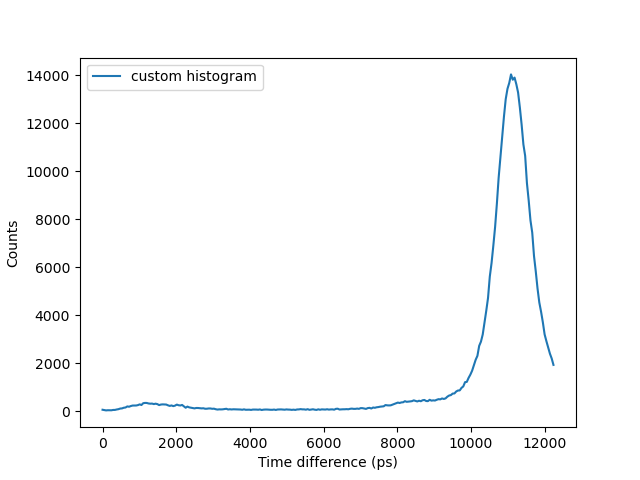

In [166]:
plt.close()

x_custom_histogram = photon_med.getIndex()
y_custom_histogram = photon_med.getData()


plt.plot(x_custom_histogram, y_custom_histogram, label='custom histogram')
plt.xlabel('Time difference (ps)')
plt.ylabel('Counts')
plt.legend()
plt.show()

In [213]:
x_custom_histogram, y_custom_histogram

(array([    0,    48,    96,   144,   192,   240,   288,   336,   384,
          432,   480,   528,   576,   624,   672,   720,   768,   816,
          864,   912,   960,  1008,  1056,  1104,  1152,  1200,  1248,
         1296,  1344,  1392,  1440,  1488,  1536,  1584,  1632,  1680,
         1728,  1776,  1824,  1872,  1920,  1968,  2016,  2064,  2112,
         2160,  2208,  2256,  2304,  2352,  2400,  2448,  2496,  2544,
         2592,  2640,  2688,  2736,  2784,  2832,  2880,  2928,  2976,
         3024,  3072,  3120,  3168,  3216,  3264,  3312,  3360,  3408,
         3456,  3504,  3552,  3600,  3648,  3696,  3744,  3792,  3840,
         3888,  3936,  3984,  4032,  4080,  4128,  4176,  4224,  4272,
         4320,  4368,  4416,  4464,  4512,  4560,  4608,  4656,  4704,
         4752,  4800,  4848,  4896,  4944,  4992,  5040,  5088,  5136,
         5184,  5232,  5280,  5328,  5376,  5424,  5472,  5520,  5568,
         5616,  5664,  5712,  5760,  5808,  5856,  5904,  5952,  6000,
      